In [7]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import yfinance as yf
import numpy as np
import pandas as pd
import json

In [8]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = api_key)

In [9]:
def get_stock_data(ticker):
    stock = yf.Ticker(ticker)
    history = stock.history(period="7d")
    dates = history.index.strftime("%Y-%m-%d").tolist()
    prices = history["Close"].tolist()

    return dates, prices

def draw_graph(dates, prices, ticker):
    import matplotlib.pyplot as plt
    plt.plot(dates, prices, color = 'pink', marker = 'o', label = ticker)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{ticker} Price History")
    plt.legend()
    plt.show()

In [10]:
### 궁금한 것
# 1. main에 response정의 안해도 초기 응답을 받을 수 있음? ai가 자동으로 인식?
# 2. tool_choice의 역할 - auto로 하면 tools의 function을 자동으로 실행해줌
# 3. tools의 function의 name이 실제 함수명과 다른데도 실행이 되는 이유? ai가 자동으로 인식?
# 4. tools의 function에 들어가는 parameter는 어떻게 정해지는지? ai가 자동으로 인식?

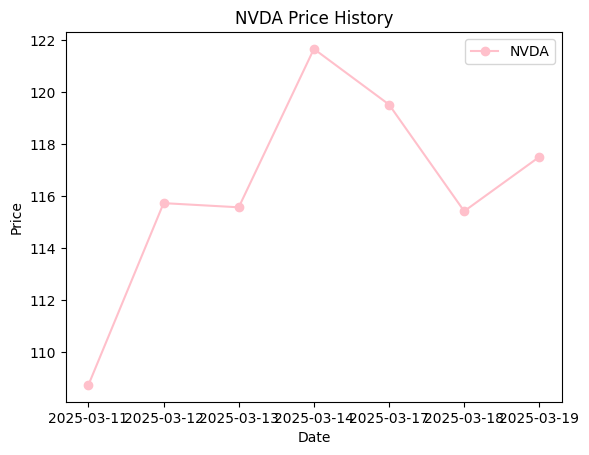

주어진 NVDA의 최근 7일간 주가 데이터를 바탕으로 향후 전망을 분석해보겠습니다.

1. **주가 변동 추세**:
   - 최근 7일 동안 NVDA의 주가는 전반적으로 상승세를 보였습니다. 이는 긍정적인 신호로 해석될 수 있으며, 시장에서의 수요 증가를 나타낼 수 있습니다.

2. **평균 가격**:
   - 최근 7일 동안 평균 주가는 116.32입니다. 이는 현재 주가가 평균에 비해 어느 정도의 위치에 있는지를 판단할 수 있는 기준이 됩니다.

3. **변동성**:
   - 변동성이 3.77로 나타났습니다. 이는 주가의 일일 변동폭이 상대적으로 작음을 의미합니다. 높은 변동성은 투자자에게 더 큰 위험을 의미할 수 있지만, 현재의 낮은 변동성은 안정적인 투자환경을 나타내는 신호일 수 있습니다.

4. **기술적 분석**:
   - 주가가 최근에 지속적으로 상승하면서, 이는 기술적으로도 매수세가 강하다는 것으로 볼 수 있습니다. 또한 최근의 최고가인 121.67에 근접하고 있다는 점에서, 단기 조정은 있을 수 있으나 장기적인 상승세를 기대할 수 있는 상황입니다.

5. **전망**:
   - 만약 주가가 더 안정적으로 유지된다면, 현재의 상승세는 계속될 가능성이 큽니다. 그러나 단기적으로 조정이 올 가능성도 배제할 수 없으므로, 이를 감안한 투자 전략이 필요합니다. 또한, 외부 요인(경제 지표, 시장 전반의 변화 등)도 고려하여 더 넓은 맥락에서 접근하는 것이 중요합니다.

결론적으로, NVDA의 주가는 긍정적인 상승세를 유지하고 있지만, 투자 시에는 조정 가능성과 외부 경제적 요인들을 충분히 고려하는 것이 중요합니다.


In [11]:
def analyze_stock_trend(ticker):
    dates, prices = get_stock_data(ticker)
    
    price_diff = np.diff(prices)
    trend = "상승" if sum(price_diff) > 0 else "하락"
    avg_price = np.mean(prices)
    volatility = np.std(prices)

    draw_graph(dates, prices, ticker)

    messages = [
        {"role": "system", "content": "너는 금융 시장을 분석하는 AI야."},
        {"role": "user", "content": f"{ticker}의 최근 7일간 주가 데이터야. 이를 기반으로 향후 전망을 분석해줘."},
        {"role": "user", "content": f"날짜: {dates}"},
        {"role": "user", "content": f"주가: {prices}"},
        {"role": "user", "content": f"주가 변동 추세: {trend}, 평균 가격: {avg_price:.2f}, 변동성: {volatility:.2f}"}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )

    return response.choices[0].message.content
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_stock_trend",
            "description": "특정 주식의 최근 7일간 가격 변동을 분석하고 향후 전망을 예측합니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {
                        "type": "string",
                        "description": "분석할 주식의 종목 코드 (예: AAPL, TSLA, GOOG)"
                    }
                },
                "required": ["ticker"]
            }
        }
    }
]
response = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {"role": "system", "content": "너는 금융 시장을 분석하는 AI야."},
        {"role": "user", "content": "엔비디아 주가가 어떻게 변화했는지 알려줘"},
        #{"role": "user", "content": "밥 메뉴추천좀"} tool기능 비활성화
    ],
    tools = tools
)

response_dict = response.to_dict()
message_content = response_dict["choices"][0]["message"]

if "tool_calls" in message_content:
    tool_call = message_content["tool_calls"][0]
    function_name = tool_call["function"]["name"]
    arguments = json.loads(tool_call["function"]["arguments"])

    if function_name == "analyze_stock_trend":
        ticker = arguments["ticker"]
        analysis_result = analyze_stock_trend(ticker)
        print(analysis_result)
else:
    print(message_content["content"])